In [1]:
import os
import re
import artm
import shutil
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy 

/home/dasha/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:29: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
data_dir = 'data_ekg'
file_source = 'vw.txt'
num_of_objects = 372

In [3]:
def separate_fold_for_cv(num_object):
    with open(file_source, 'r') as fin:
        with open( os.path.join(data_dir, 'test.txt'), 'w') as test:
            with open(os.path.join(data_dir, 'true_labels.txt'), 'w')  as label:
                with open(os.path.join(data_dir, 'train.txt'), 'w') as train:
                        for index, line in enumerate(fin.readlines()):
                            if index==num_object:
                                test.write("%s\n"%(line.partition('|')[0]))
                                line_tmp = "%s "%(line.split('|',1)[1][:-1])
                                str_tmp = re.findall(r'\:(.*?)\ ', line_tmp)
                                label.write("%s %s\n"%(str_tmp[0],  str_tmp[1]))
                            else:
                                train.write(line)

In [4]:
def create_batches():
    batch_vectorizer = None
    new_folder = os.path.join(data_dir, 'data_batches')
    target_folder_train = "%s%s"%(new_folder, '_train')
    target_folder_test = "%s%s"%(new_folder, '_test')
    batch_vectorizer = artm.BatchVectorizer(batch_size = 100000, data_path = os.path.join(data_dir, 'train.txt'),\
                                            data_format='vowpal_wabbit', target_folder=target_folder_train)
    batch_vectorizer = artm.BatchVectorizer(batch_size = 100000, data_path = os.path.join(data_dir, 'test.txt'),\
                                            data_format='vowpal_wabbit', target_folder=target_folder_test)
    os.rename(os.path.join(target_folder_train, 'aaaaaa.batch'),os.path.join(target_folder_train, 'train.batch'))
    os.rename(os.path.join(target_folder_test,  'aaaaaa.batch'),os.path.join(target_folder_test, 'test.batch'))
    folder_for_dict = os.path.join(data_dir, 'for_dict')
    os.mkdir(folder_for_dict)
    shutil.copy (os.path.join(target_folder_train, 'train.batch'), folder_for_dict)
    shutil.copy (os.path.join(target_folder_test, 'test.batch'),   folder_for_dict)
    shutil.copy (os.path.join(data_dir, 'true_labels.txt'), target_folder_test)

In [5]:
num_topics = 5
num_collection_passes = 40
labels_class_weight = [1]*num_collection_passes
tokens_class_weight = [1]*num_collection_passes
num_document_passes = [1]*num_collection_passes
labels_class='labels'
tokens_class = '@default_class'
model_ans_iteration_folds  = {}
perplexity_scores = {}
sparsity_psi = {}

In [6]:
import sys
sys.path.insert(0, '/home/dasha')
from telegram_logger import TelegramLogger
tl = TelegramLogger(name='artm', print_dual_logging=False)

In [8]:
%%time
for index in xrange(num_of_objects):
    os.mkdir(data_dir)
    separate_fold_for_cv(index)
    create_batches()
    test_labels_file    = os.path.join(data_dir, 'true_labels.txt')
    true_p_cd = []
    with open(test_labels_file, 'r') as fin:
        for line in fin.readlines():
            if int(line.split(" ")[0]):
                true_p_cd.append(0)
            else:
                true_p_cd.append(1)
    true_p_cd = numpy.asarray(true_p_cd) 
    batch_vectorizer_fit = artm.BatchVectorizer(data_path = os.path.join(data_dir, 'data_batches_train') , data_format="batches")
    batch_vectorizer_test = artm.BatchVectorizer(data_path = os.path.join(data_dir, 'data_batches_test'), data_format="batches")
    dictionary = artm.Dictionary()
    dictionary.gather(data_path=os.path.join(data_dir, 'for_dict'))
    model = artm.ARTM(num_topics=num_topics, dictionary = dictionary, cache_theta=True)
    # Перплексия
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    # Разреженность p(c|t)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='labels'))

    for iteration in xrange(num_collection_passes):
        if iteration not in model_ans_iteration_folds:
            model_ans_iteration_folds[iteration] = []
            perplexity_scores[iteration] = []
            sparsity_psi[iteration] = []
            
        model.class_ids = {tokens_class: tokens_class_weight[iteration], labels_class: labels_class_weight[iteration]}
        model.num_document_passes = num_document_passes[iteration]
        
        model.fit_offline(num_collection_passes=1, batch_vectorizer=batch_vectorizer_fit)
        
        perplexity_scores[iteration].append(model.score_tracker['perplexity_score'].last_value)

        sparsity_psi[iteration].append(model.score_tracker['sparsity_phi_score'].last_value)
        
        test_theta =  model.transform(batch_vectorizer=batch_vectorizer_test, predict_class_id='labels').reset_index()
        test_theta.columns = ['index', 'ans']
        model_ans_iteration_folds[iteration].append(float(test_theta[test_theta['index']=='label1'].ans))
    # p(t|c)
    theta = model.get_theta()
    p_d = 1.0/(num_of_objects-1)
    p_t = theta
    p_t = p_t.multiply(p_d)
    p_t = p_t.sum(axis = 1)

    phi = model.get_phi().reset_index()
    p_ct = phi[(phi['index']=='label0') | (phi['index']=='label1')].set_index('index')
    p_ct = p_ct.multiply(p_t)
    p_tc = p_ct.div(p_ct.sum(axis = 1), axis = 'index' ).T
    p_tc.to_csv("p_tc{}.csv".format(index) )
    shutil.rmtree (data_dir)

CPU times: user 1h 8min 56s, sys: 4min 17s, total: 1h 13min 14s
Wall time: 1h 12min 38s


In [114]:
# Ответы по каждому обьекту
true_p_cd = []
with open ('vw.txt', 'r') as fin:
    for index, line in enumerate(fin.readlines()):
        line_tmp = "%s "%(line.split('|',1)[1][:-1])
        str_tmp = re.findall(r'\:(.*?)\ ', line_tmp)
        if int(str_tmp[0]):
            true_p_cd.append(0)
        else:
            true_p_cd.append(1)

In [ ]:
iterations = [key+1 for key in model_ans_iteration_folds.keys()]
auc_scores = [sklearn.metrics.roc_auc_score(numpy.asarray(true_p_cd), numpy.asarray(value)) for key, value in model_ans_iteration_folds.iteritems()]

In [12]:
with open('auc_50_topics_wc_1000.txt', 'w') as fout:
    for auc in auc_scores:
           fout.write("%f\n"%(auc))

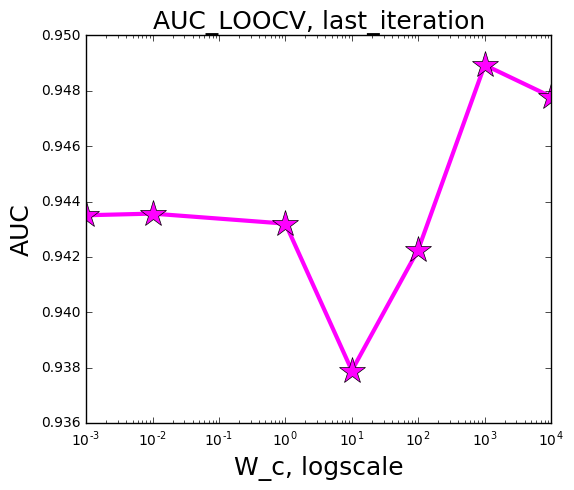

In [51]:
# Последняя итерация для каждой модели |T|
#topics = [3,5,7,9,11, 13]
w_c = [0.001, 0.01, 1, 10, 100, 1000, 10000]
auc_last_iteration = []
for i in w_c:
    with open('auc_5_topics_wc_{}.txt'.format(i), 'r') as fin:
        auc_last_iteration.append([float(line) for line in fin.readlines()][-1])
#with open('auc_5_topics_wc_{}.txt'.format(200), 'r') as fin: 
#    tmp = [float(line) for line in fin.readlines()][-1]
plt.figure(figsize=(6,5))
plt.plot(w_c, auc_last_iteration, color = 'magenta', lw = 3, marker='*', markersize=20)
#plt.plot([200], auc_last_iteration[5], color = 'blue', lw = 3, marker='*', markersize=20)
#plt.plot([200], tmp , color = 'magenta', lw = 3, marker='*', markersize=20)
plt.xlabel("W_c, logscale", fontsize = 18)
plt.ylabel('AUC', fontsize = 18)
plt.xscale('log')
plt.title('AUC_LOOCV, last_iteration', fontsize = 18)
#plt.ylim([0.93, 0.95])
#plt.xlim([0.001, 100000])
plt.savefig('auc_last_iteration_w_c.eps', format = 'eps')
plt.show()

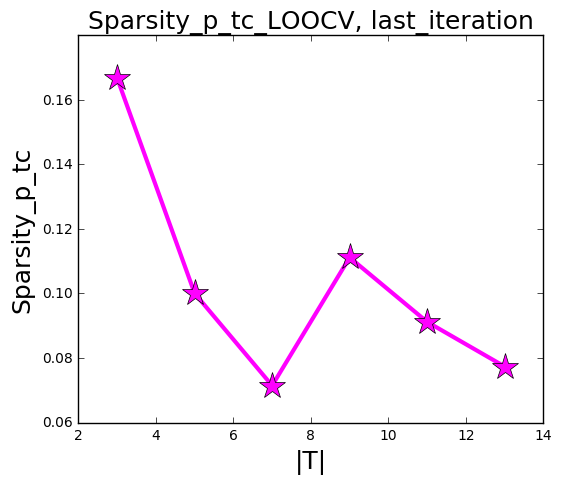

In [73]:
# Последняя итерация для каждой модели |T|
topics = [3,5,7,9,11, 13]
auc_last_iteration = []
for i in topics:
    with open('sparsity_psi_{}_topics_wc_1.txt'.format(i), 'r') as fin:
        auc_last_iteration.append([float(line) for line in fin.readlines()][36])
        
plt.figure(figsize=(6,5))
plt.plot(topics, auc_last_iteration, lw = 3, marker='*', markersize=20, color = 'magenta')
plt.xlabel("|T|", fontsize = 18)
plt.ylabel('Sparsity_p_tc', fontsize = 18)
plt.title('Sparsity_p_tc_LOOCV, last_iteration', fontsize = 18)
#plt.ylim([0.93, 0.95])
#plt.xlim([0.001, 100000])
#plt.savefig('auc_last_iteration_t.eps', format = 'eps')
plt.show()

In [125]:
iterations = [x+1 for x in range(49)]

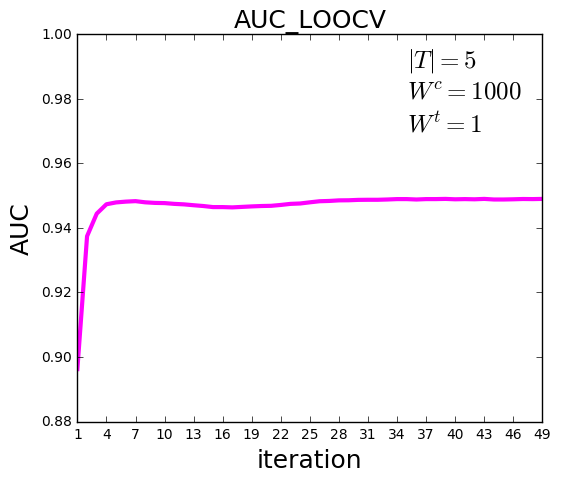

In [135]:
# Отдельно каждый график
num_topics = [5]
w_c = [1000]
for i in w_c:
    with open('auc_5_topics_wc_{}.txt'.format(i), 'r') as fin:
        plt.figure(figsize=(6,5))
        plt.plot(iterations,[float(line) for line in fin.readlines()], color = 'magenta', lw = 3)
        plt.xlabel("iteration", fontsize = 18)
        plt.ylabel('AUC', fontsize = 18)
        plt.title('AUC_LOOCV', fontsize = 18)
        plt.ylim([0.88, 1])
        x = [1,49]
        plt.xlim(x)
        plt.xticks(np.arange(min(x), max(x)+1, 3))
        plt.text(35, 0.99, '$|T|=5$', fontsize=18)
        plt.text(35, 0.98, '$W^c=1000$',  fontsize=18)
        plt.text(35, 0.97, '$W^t=1$', fontsize=18)
plt.savefig('auc_5_topics_wc_{}.eps'.format(i), format = 'eps')
plt.show()

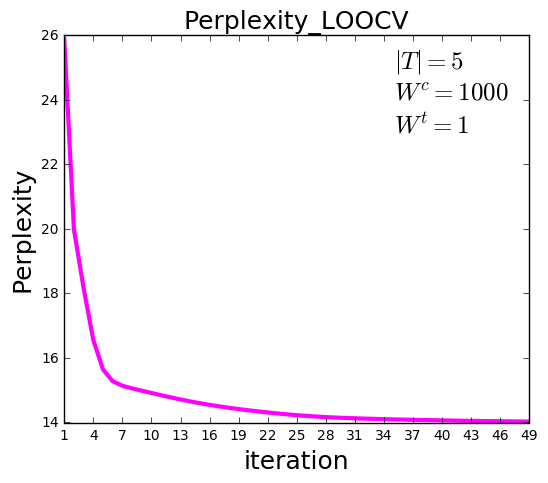

In [146]:
# Отдельно каждый график
num_topics = [5]
w_c = [1000]
for i in w_c:
    with open('perplexity_5_topics_wc_{}.txt'.format(i), 'r') as fin:
        plt.figure(figsize=(6,5))
        plt.plot(iterations,[float(line) for line in fin.readlines()], color = 'magenta', lw = 3)
        plt.xlabel("iteration", fontsize = 18)
        plt.ylabel('Perplexity', fontsize = 18)
        plt.title('Perplexity_LOOCV', fontsize = 18)
        x = [1, 49]
        plt.xlim(x)
        plt.xticks(np.arange(min(x), max(x)+1, 3))
        plt.text(35, 25, '$|T|=5$', fontsize=18)
        plt.text(35, 24, '$W^c=1000$',  fontsize=18)
        plt.text(35, 23, '$W^t=1$', fontsize=18)
plt.savefig('perplexity_5_topics_wc_{}.eps'.format(i), format = 'eps')
plt.show()

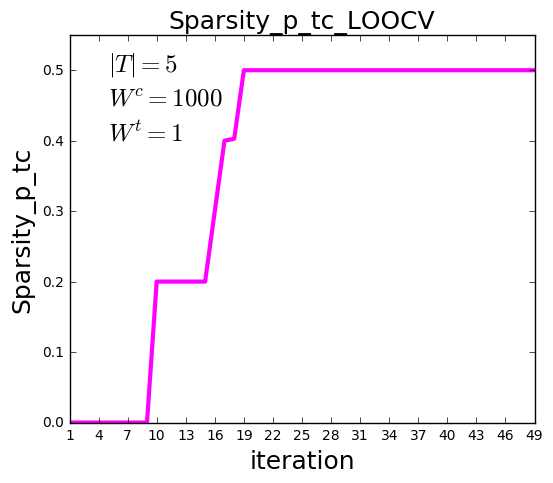

In [155]:
# Отдельно каждый график
num_topics = [5]
w_c = [1000]
for i in w_c:
    with open('sparsity_psi_5_topics_wc_{}.txt'.format(i), 'r') as fin:
        plt.figure(figsize=(6,5))
        plt.plot(iterations,[float(line) for line in fin.readlines()], color = 'magenta', lw = 3)
        plt.xlabel("iteration", fontsize = 18)
        plt.ylabel('Sparsity_p_tc', fontsize = 18)
        plt.title('Sparsity_p_tc_LOOCV', fontsize = 18)
        x = [1, 49]
        plt.xlim(x)
        plt.xticks(np.arange(min(x), max(x)+1, 3))
        plt.ylim([0, 0.55])
        plt.text(5, 0.5, '$|T|=5$',  fontsize=18)
        plt.text(5, 0.45, '$W^c=1000$',  fontsize=18)
        plt.text(5, 0.40, '$W^t=1$',  fontsize=18)
plt.savefig('sparsity_psi_5_topics_wc_{}.eps'.format(i), format = 'eps')
plt.show()